# 🍫Tune your RAG data pipeline using parameter search and evaluate performance

> ⚠️ This notebook can be run on your local machine or on a virtual machine and requires [Docker Compose](https://docs.docker.com/desktop/).

> 💡 This notebook allows you to perform parameter search, launch multiple runs and compare performance. Check out our [basic notebook](./evaluation.ipynb) if you want to configure a single run.

In this notebook we demonstrate how to set up a Retrieval-Augmented Generation (RAG) system, perform parameter search and compare the performance of different runs on an example dataset. We will:

- Set up an environment and a [Weaviate](https://weaviate.io/platform) Vector Store
- Define over which parameters should be searched
- Run a number of RAG indexing pipelines with the parameters defined in the search grid
- Run performance evaluation
- Explore results

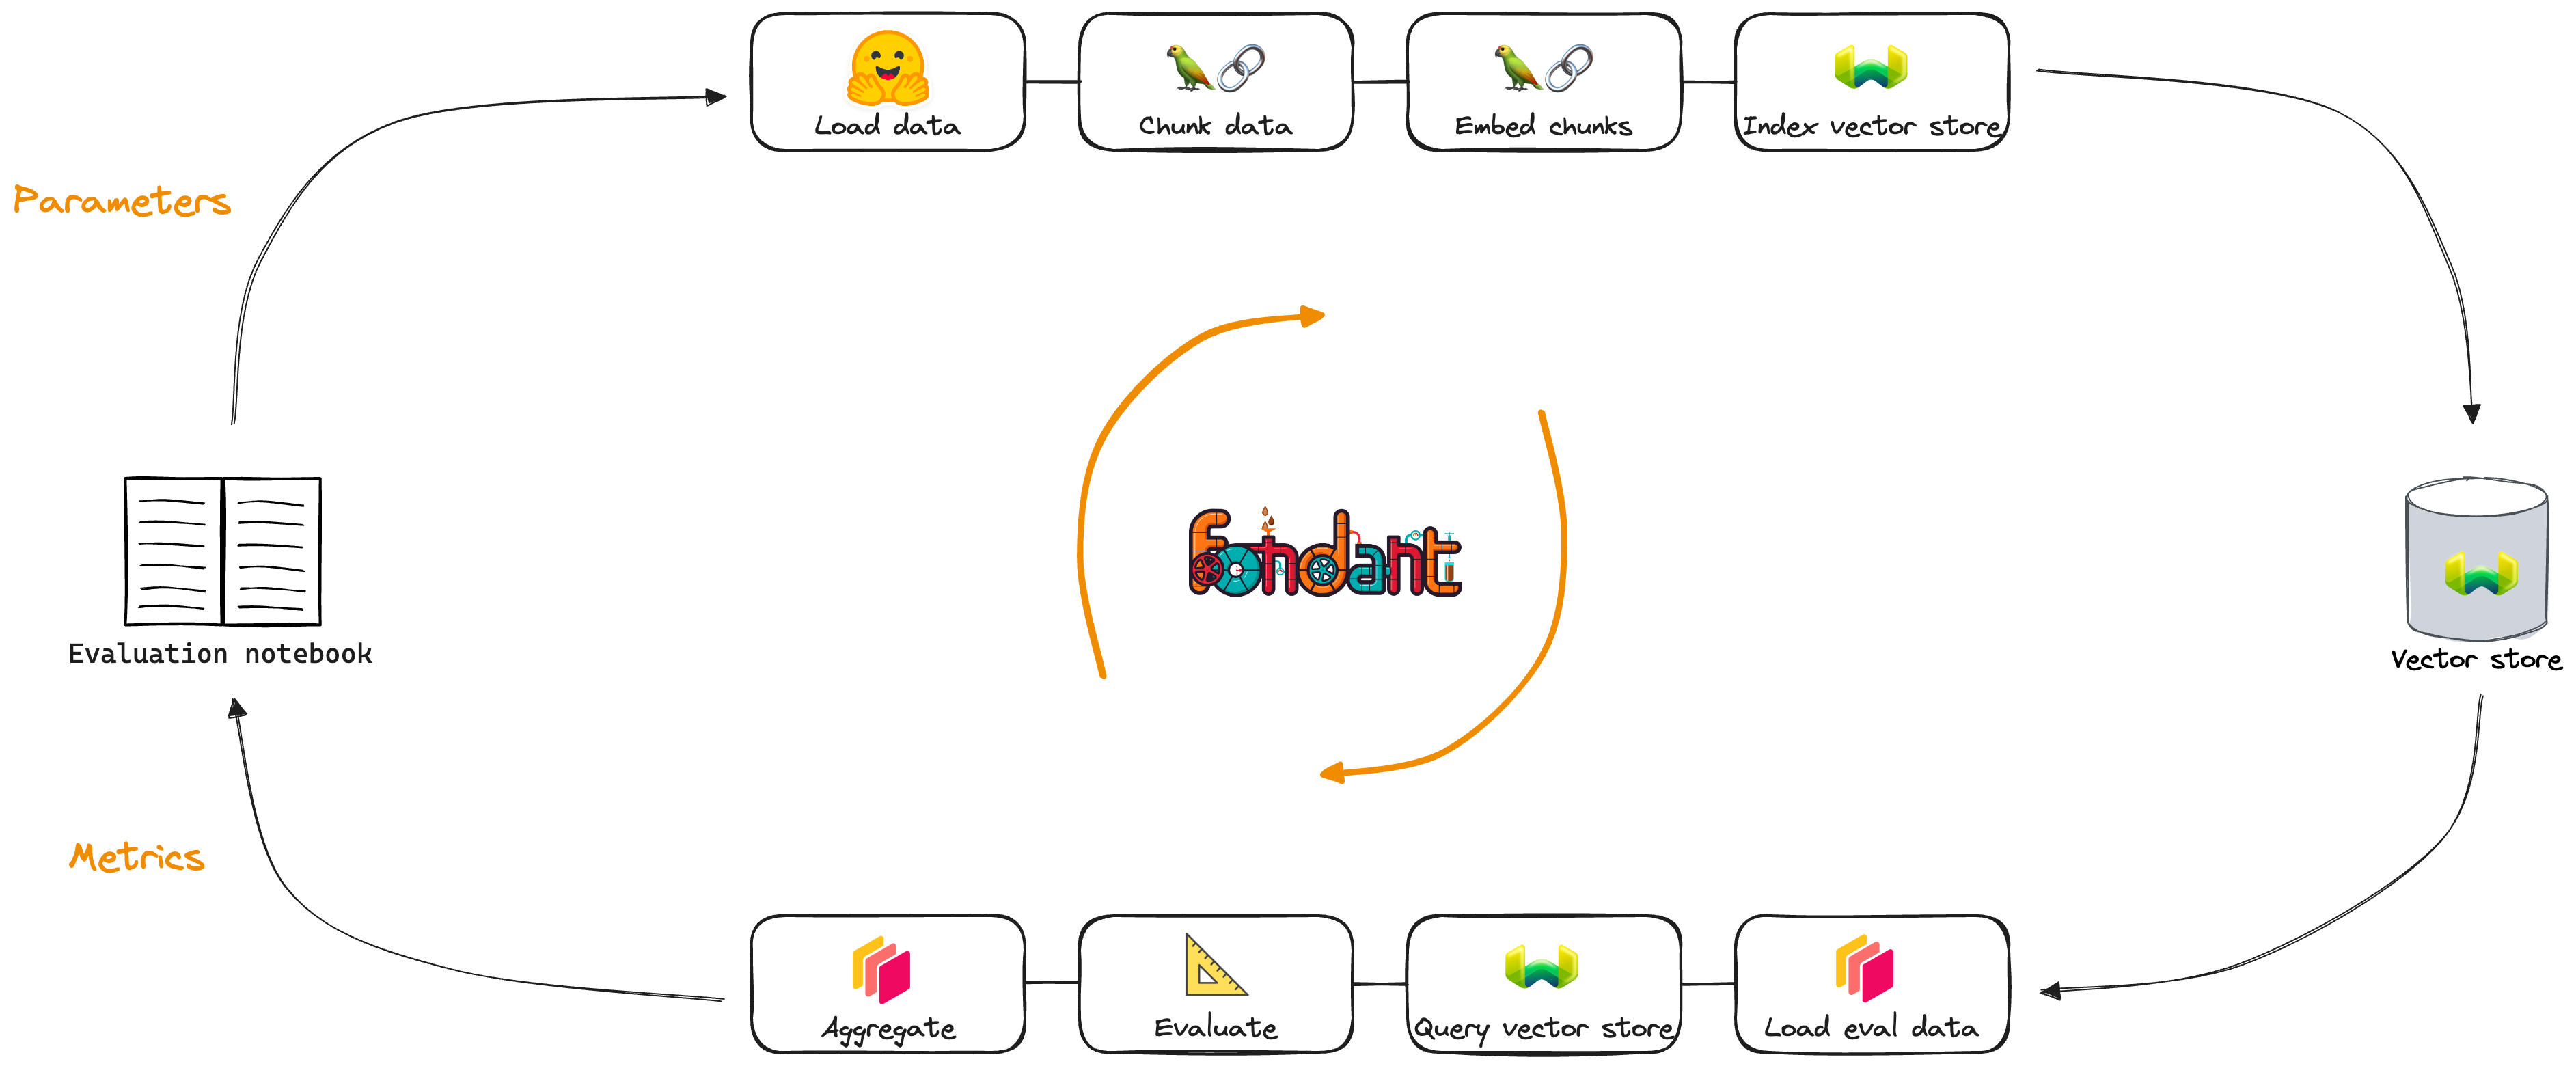

We will use [Fondant](https://fondant.ai), a hub and framework for easy and shareable data processing, as it has the following advantages for RAG evaluation:

- __Ease-of-use__
    - Easily adaptable: change parameters and swap [components](https://fondant.ai/en/latest/components/hub/) by changing only a few lines of code
    - Easily extendable: create your own [custom components](https://fondant.ai/en/latest/components/custom_component/), e.g. for chunking, and plug them into the pipeline easily
    - Reusable & shareable: reuse your processing components in different pipelines and share them with the [community](https://discord.gg/HnTdWhydGp)
- __Processing speed__
    - Parallel processing out of the box; speeds up processing of large datasets especially
    - [Data caching](https://fondant.ai/en/latest/caching/) after each step so that it does not need to be repeated in subsequent runs; increases speed and reduces compute cost; useful when performing parameter search over multiple runs especially
- __Production-readiness__
    - Dockerized: steps are dockerized which makes the [pipeline](https://fondant.ai/en/latest/pipeline/) ready for production as is. Different [runners](https://fondant.ai/en/latest/runners/local/) are available for Docker Compose (used in this notebook), Vertex, SageMaker and Kubeflow.
    - Lineage & traceability: use the [data explorer](https://fondant.ai/en/latest/data_explorer/) to check the evolution of data after each step

 
Please share your experiences or let us know how we can improve through our [Discord](https://discord.gg/HnTdWhydGp) or on [GitHub](https://github.com/ml6team/fondant-usecase-RAG). And of course feel free to give us a [star](https://github.com/ml6team/fondant-usecase-RAG) if you like what we are doing!

## Set up environment

Check if docker compose is installed and the docker daemon is running

In [ ]:
!docker compose version
!docker info

### Set up Fondant

In [ ]:
!pip install -r ../requirements.txt

In [ ]:
from utils import get_host_ip, create_directory_if_not_exists, output_results
from utils_param_search import run_parameters_search

## Initiate the Weaviate vector store

> ⚠️ For Apple M1/M2 chip users:
> 
> - In Docker Desktop Dashboard `Settings -> Features in development`, make sure to uncheck `Use containerid` for pulling and storing images. More info [here](https://docs.docker.com/desktop/settings/mac/#beta-features)
> - Make sure that Docker uses linux/amd64 platform and not arm64 (cell below should take care of that)

In [ ]:
import os
os.environ["DOCKER_DEFAULT_PLATFORM"]="linux/amd64"

Run Weaviate with Docker compose

In [ ]:
!docker compose -f weaviate/docker-compose.yaml up --detach

Make sure you have Weaviate client v3

In [ ]:
!pip install "weaviate-client==3.*"

Make sure the vectorDB is running and accessible

In [ ]:
import weaviate

local_weaviate_client = weaviate.Client("http://localhost:8080")
local_weaviate_client.schema.get()

## Parameter search

Parameter search allows you try out different configurations of pipelines and compare their performance. Currently only grid search (which probes all possible combinations of different parameters) has been implemented but more will be added soon.

The first pipeline run is `pipeline_index.py`, which processes text data and loads it into the vector database. It consists of the following steps:

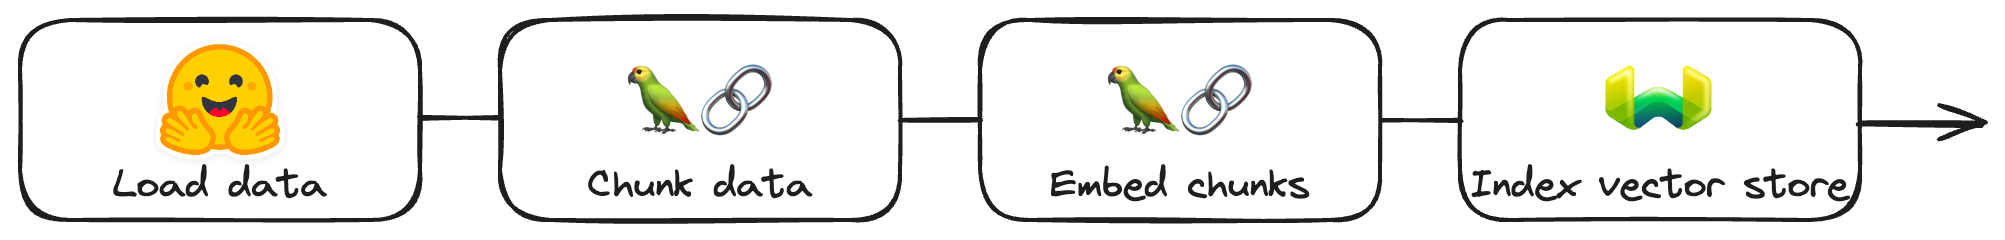

- [Data Loading](https://github.com/ml6team/fondant/tree/main/components/load_from_parquet): loads data from parquet file, default the first 1000 rows of the example [wikitext](https://huggingface.co/datasets/wikitext) dataset
- [Text Chunking](https://github.com/ml6team/fondant/tree/main/components/chunk_text): divides the text into sections of a certain size and with a certain overlap
- [Text Embedding](https://github.com/ml6team/fondant/tree/main/components/embed_text): embeds each chunk as a numerical vector, default using a HuggingFace model; use a machine with GPU for large datasets
- [Write to Weaviate](https://github.com/ml6team/fondant/tree/main/components/index_weaviate): writes data and embeddings to the vector store

The second pipeline is `pipeline_eval.py` which evaluates retrieval performance using the questions provided in your test dataset.

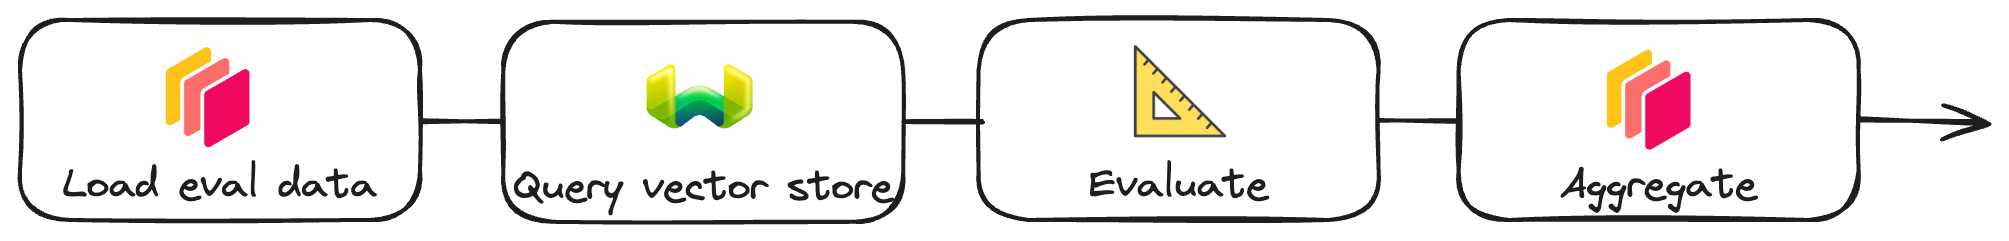

- [Evaluation Data Loading](https://github.com/ml6team/fondant/tree/main/components/load_from_csv): loads the evaluation (question) dataset
- [Text Embedding](https://github.com/ml6team/fondant/tree/main/components/embed_text): embeds the questions
- [Retrieve Relevant Documents](https://github.com/ml6team/fondant/tree/main/components/retrieve_from_weaviate): retrieves for each question the chunks in the vector store that resemble it most
- [Evaluate the RAG configuration](https://github.com/ml6team/fondant/tree/main/components/evaluate_ragas): This component evaluates the retriever from the RAG pipeline using metrics computed with [RAGAS](https://docs.ragas.io/en/latest/index.html)' evaluation framework. The metrics computed are the [precision](https://docs.ragas.io/en/latest/concepts/metrics/context_precision.html) and the [relevancy](https://docs.ragas.io/en/latest/concepts/metrics/context_relevancy.html) of the retrieved context.
- [Aggregate Evaluation Scores](https://github.com/ml6team/fondant-usecase-RAG/tree/main/src/components/aggregate_eval_results): This last component aggregates the scores over all questions for each metric computed.

> 💡 When you want to run the evaluation pipeline with your own data, you will need a validation question set. For an example, see `./evaluation_datasets/wikitext_1000_q.csv`

### Set up parameter search

Select parameters to search over

- `chunk_sizes`: size of each text chunk, in number of characters ([chunk text](https://github.com/ml6team/fondant/tree/main/components/chunk_text) component)
- `chunk_overlaps`: overlap between chunks ([chunk text](https://github.com/ml6team/fondant/tree/main/components/chunk_text) component)
- `embed_models`: model used to embed ([embed text](https://github.com/ml6team/fondant/tree/main/components/embed_text) component)
- `top_ks`: number of retrieved chunks taken into account for evaluation ([retrieve](https://github.com/ml6team/fondant/tree/main/components/retrieve_from_weaviate) component)

In [ ]:
# parameter search
chunk_sizes = [256, 512]
chunk_overlaps = [10, 50]
embed_models = [("huggingface","all-MiniLM-L6-v2"), ("huggingface", "BAAI/bge-base-en-v1.5")]
top_ks = [2, 3]

⚠️ If you want to use ChatGPT you will need an [OpenAI API key](https://platform.openai.com/docs/quickstart) (see TODO below)

In [ ]:
# Define evaluation dataset to load (csv file with a "question" column)
extra_volumes = [str(os.path.join(os.path.abspath('.'), "evaluation_datasets")) + ":/data"]

# configurable parameters shared by indexing and evaluation pipeline (further below)
host_ip = get_host_ip() #get the host IP address to enable Docker access to Weaviate

BASE_PATH = "./data-dir"
BASE_PATH = create_directory_if_not_exists(BASE_PATH) #create a folder to store the pipeline data if it doesn't exist

fixed_args = {
    "base_path":BASE_PATH,
    "weaviate_url":f"http://{host_ip}:8080", # IP address 
}
fixed_index_args = {
    "n_rows_to_load":1000,
}
fixed_eval_args = {
    "csv_dataset_uri":"/data/wikitext_1000_q.csv", #make sure it is the same as mounted file
    "csv_separator":";",
    "evaluation_module": "langchain.llms",
    "evaluation_llm":"OpenAI",
    "evaluation_llm_kwargs":{"openai_api_key": ""}, #TODO Specify your key if you're using OpenAI
    "evaluation_metrics":["context_precision", "context_relevancy"]
}

### Run parameter search

> 💡 The first time you run a pipeline, you need to download a docker image for each component which may take a minute. The second time, processing will start instantly. Moreover, steps that have been processed before are cached and will be skipped in subsequent runs which will speed things up even further.

In [ ]:
parameters_search_results = run_parameters_search(
    extra_volumes=extra_volumes,
    fixed_args=fixed_args,
    fixed_index_args=fixed_index_args,
    fixed_eval_args=fixed_eval_args,
    chunk_sizes=chunk_sizes,
    chunk_overlaps= chunk_overlaps,
    embed_models=embed_models,
    top_ks=top_ks,
)

## Explore Results

Compare the performance of your runs below

In [ ]:
results_df = output_results(results=parameters_search_results)
results_df.to_csv("./param_search_results.csv") #save your results

## Explore data

You can also check your data and results at each step in the pipelines using the Fondant data explorer. The first time you run the data explorer, you need to download the docker image which may take a minute. Refreshing you browser window when it is ready should do the trick.

Enjoy the exploration! 🍫 

In [ ]:
from fondant.explore import run_explorer_app

run_explorer_app(base_path=fixed_args["pipeline_dir"])

## Clean up your environment

After your pipeline run successfully, you should clean up your environment and stop the weaviate database.

In [ ]:
!docker compose -f weaviate/docker-compose.yaml down

## Feedback

Please share your experiences or let us know how we can improve through our [Discord](https://discord.gg/HnTdWhydGp) or on [GitHub](https://github.com/ml6team/fondant-usecase-RAG). And of course feel free to give us a [star](https://github.com/ml6team/fondant-usecase-RAG) if you like what we are doing!

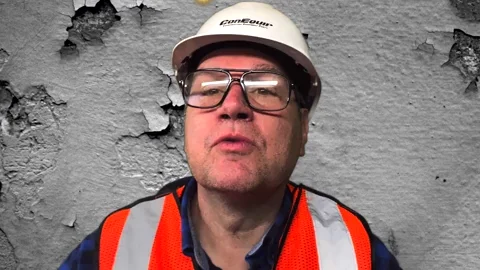
